This is a working file for the Deep Learning Assignment. In this notebook, model tuning is performed to find an optimal modification to the transfer learning model (VGG16).

Please refer to the main notebook file of the project: Assignment_DL_Jakob_Tjurlik.ipynb

## Pre-load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import ipython_config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

utils.set_random_seed(42)

file_dir = ipython_config.FILE_DIR
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
classes, class_indices = np.unique(labels, return_index=True)
n_classes=len(classes)

Mounted at /content/drive


In [ ]:
# Load datasets
with open(file_dir + 'datasets.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

## Initial VGG16

In [ ]:
# Load pre-trained VGG16 model
vgg_model = VGG16(include_top=False, input_shape=(120, 120, 3))

# Freeze the layers of the VGG16 model up to a certain point
for layer in vgg_model.layers:
    layer.trainable = False

# Add layers
model_transfer = models.Sequential()
model_transfer.add(vgg_model)
model_transfer.add(layers.Flatten())
model_transfer.add(layers.Dense(128, activation='relu'))
model_transfer.add(layers.Dense(n_classes, activation='softmax'))

# Compile the model
model_transfer.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history9 = model_transfer.fit(X_train, y_train,
                                      epochs=30,
                                      batch_size=64,
                                      validation_data=(X_val, y_val),
                                      verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model_transfer.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
235/235 [==============================] - 34s 110ms/step - loss: 4.3985 - accuracy: 0.4984 - val_loss: 1.9749 - val_accuracy: 0.6880
Epoch 2/30
235/235 [==============================] - 23s 99ms/step - loss: 1.5328 - accuracy: 0.7538 - val_loss: 1.1743 - val_accuracy: 0.7964
Epoch 3/30
235/235 [==============================] - 24s 103ms/step - loss: 0.9721 - accuracy: 0.8264 - val_loss: 0.8732 - val_accuracy: 0.8474
Epoch 4/30
235/235 [==============================] - 25s 108ms/step - loss: 0.6963 - accuracy: 0.8627 - val_loss: 0.7156 - val_accuracy: 0.8684
Epoch 5/30
235/235 [==============================] - 30s 126ms/step - loss: 0.5321 - accuracy: 0.8870 - val_loss: 0.6162 - val_accuracy: 0.8826
Epoch 6/30
235/235 [==============================] - 26s 109ms/step - loss: 0.4182 - accuracy: 0.9049 - val_loss: 0.5538 - val_accuracy: 0.8922
Epoch 7/30
235/235 [==============================] - 29s 125ms/st

## Functions

In [ ]:
# ROC curves

def plot_roc(model, classes=classes):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import LabelBinarizer

    n_classes = len(classes)

    # Binarize the target by one-hot-encoding in a OvR fashion
    label_binarizer = LabelBinarizer().fit(y_train)
    y_true = label_binarizer.transform(y_test)

    # Predict classes
    y_pred = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC and AUC
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    plt.plot(fpr_micro, tpr_micro,
             label=f'Micro-average ROC (area = {roc_auc_micro:.2f})',
             c='deeppink', ls=':', lw=4)

    plt.plot(fpr_macro, tpr_macro,
             label=f'Macro-average ROC (area = {roc_auc_macro:.2f})',
             c='navy', ls=':', lw=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass Receiver Operating Characteristic - test set')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
def plot_confusion_matrix(model, X, y, dataset_name, classes=classes):
    from sklearn.metrics import confusion_matrix, classification_report
    n_classes = len(classes)

    # Predict classes
    y_pred = np.argmax(model.predict(X), axis=1)

    # Convert one-hot encoded y to class labels
    y_true = np.argmax(y, axis=1)

    print(y_pred, y_pred.shape)
    print(y_true, y_true.shape)

    # Print classification report
    print(f'Classification report of the {dataset_name} set:')
    print(classification_report(y_true, y_pred, target_names=classes))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d',
                cmap=sns.cubehelix_palette(as_cmap=True),
                xticklabels=np.arange(n_classes), yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {dataset_name} set')
    plt.show()
    print()

In [ ]:
# Loss and accuracy plots

def plot_history(history):
    # Define relevant metrics
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    # Define plot style
    plt.figure(figsize= (22, 8))
    plt.style.use('ggplot')

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(tr_acc, label='Training Accuracy', lw=4, c='firebrick')
    plt.plot(val_acc, label='Validation Accuracy', lw=4, c='darkgreen')
    plt.scatter(val_acc.index(max(val_acc)), max(val_acc), c='mediumblue',
                s= 100, label=f'Best epoch = {val_acc.index(max(val_acc))}')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Training and Validation Accuracy', fontsize=18, fontweight='bold')
    plt.legend(fontsize=14)
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(tr_loss, label='Training Loss', lw=4, c='firebrick')
    plt.plot(val_loss, label='Validation Loss', lw=4, c='darkgreen')
    plt.scatter(val_loss.index(min(val_loss)), min(val_loss), c='mediumblue',
                s= 100, label=f'Best epoch = {val_loss.index(min(val_loss))}')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Training and Validation Loss', fontsize=18, fontweight='bold')
    plt.legend(fontsize=14)
    plt.grid(True)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.125)
    plt.show()

## Model performance

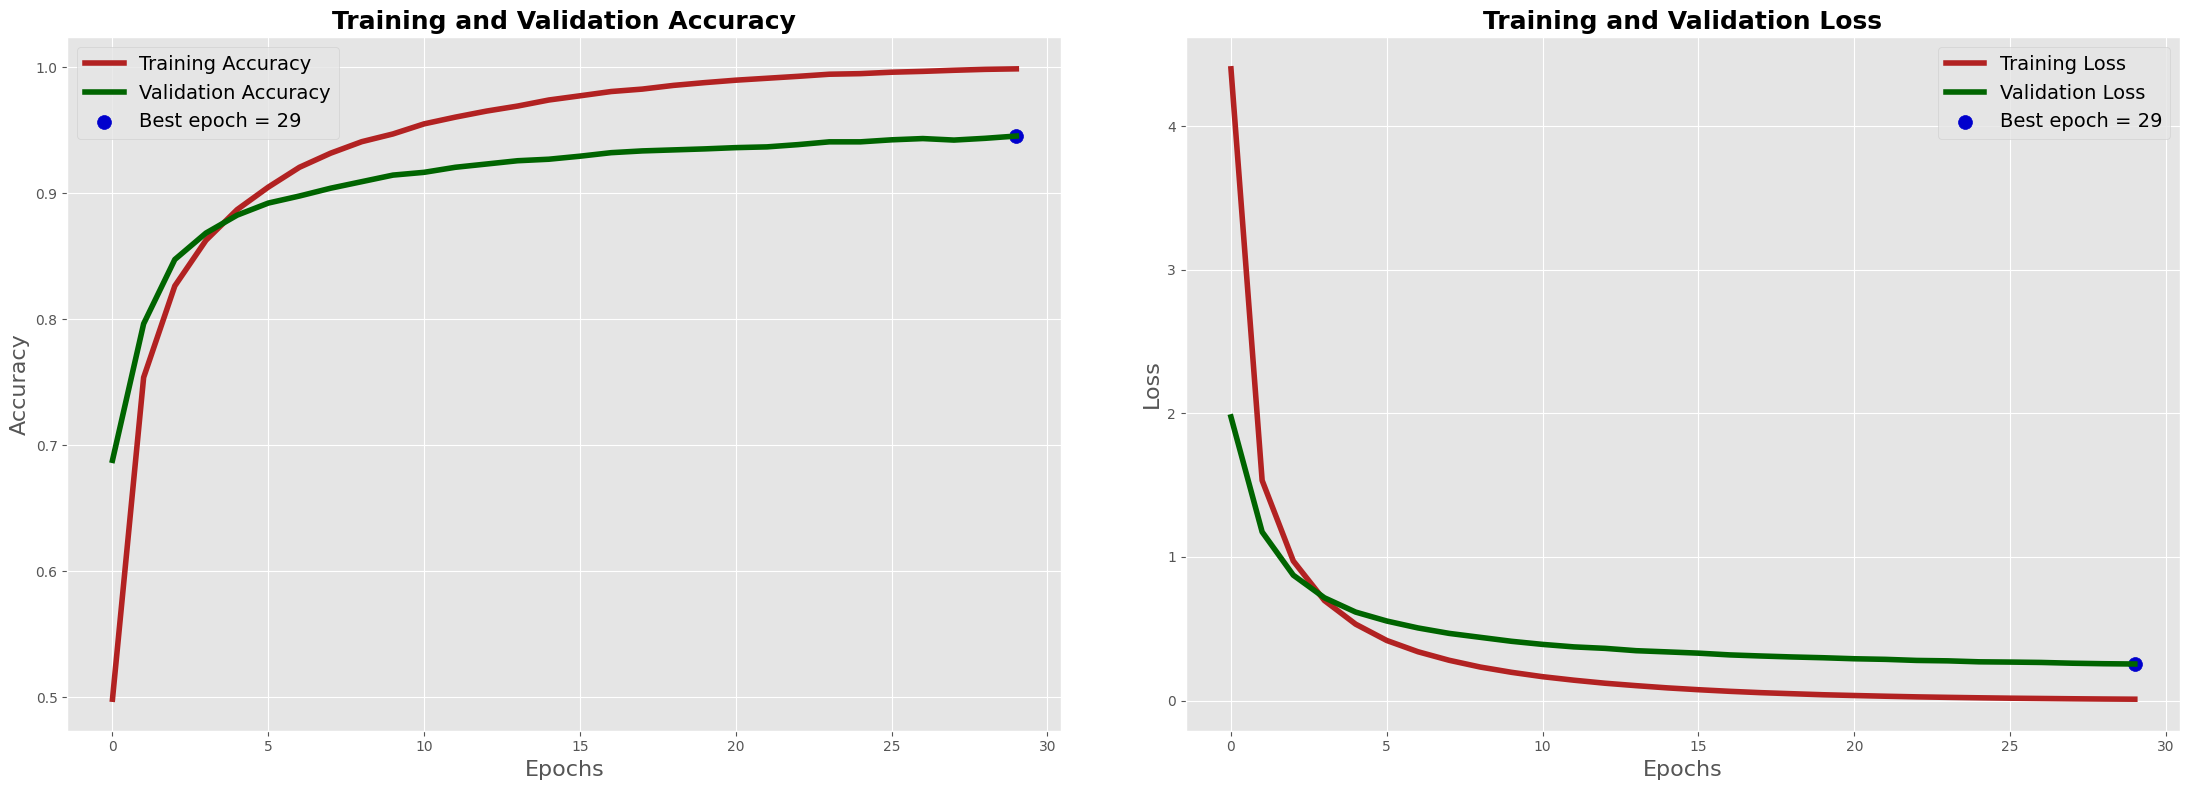

157/157 [==============================] - 7s 42ms/step


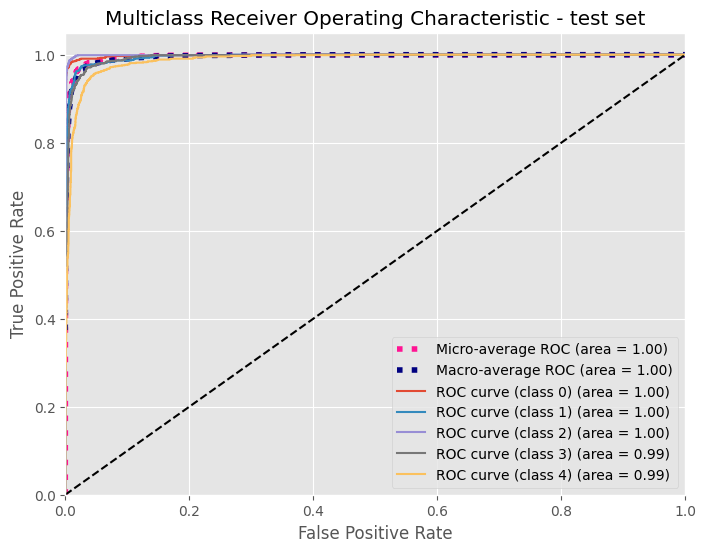

157/157 [==============================] - 7s 43ms/step
[2 1 0 ... 4 3 0] (5000,)
[2 1 0 ... 4 3 0] (5000,)
Classification report of the test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.98      0.97      0.97      1000
        Colon adenocarcinoma       0.94      0.94      0.94      1000
          Lung Benign Tissue       0.98      0.98      0.98      1000
Lung Squamous Cell Carcinoma       0.92      0.94      0.93      1000
         Lung adenocarcinoma       0.90      0.90      0.90      1000

                    accuracy                           0.94      5000
                   macro avg       0.95      0.94      0.95      5000
                weighted avg       0.95      0.94      0.95      5000



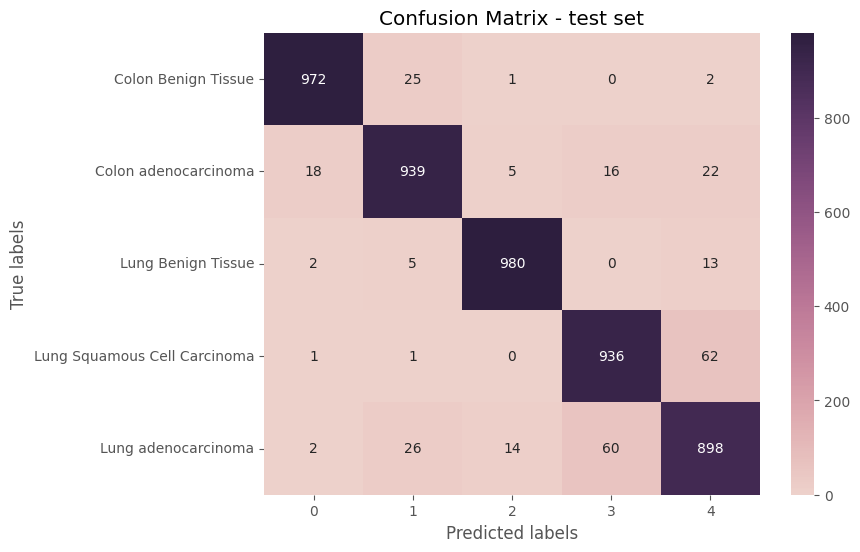

In [ ]:
plot_history(history9)
plot_roc(model_transfer)
plot_confusion_matrix(model_transfer, X_test, y_test, 'test')

## Extended model

In [ ]:
# Add layers
model_transfer2 = models.Sequential()
model_transfer2.add(vgg_model)
model_transfer2.add(layers.Flatten())
model_transfer2.add(layers.Dense(256, activation='relu'))
model_transfer2.add(layers.Dropout(0.4))
model_transfer2.add(layers.Dense(128, activation='relu'))
model_transfer2.add(layers.Dense(n_classes, activation='softmax'))

# Compile the model
model_transfer2.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
history10 = model_transfer2.fit(X_train, y_train,
                                      epochs=20,
                                      batch_size=64,
                                      validation_data=(X_val, y_val),
                                      verbose=1)

# Evaluate the model on the test set
test_loss, test_acc = model_transfer2.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/20
235/235 [==============================] - 30s 115ms/step - loss: 7.3093 - accuracy: 0.3813 - val_loss: 1.6349 - val_accuracy: 0.6764
Epoch 2/20
235/235 [==============================] - 26s 109ms/step - loss: 2.9449 - accuracy: 0.5927 - val_loss: 0.9455 - val_accuracy: 0.7934
Epoch 3/20
235/235 [==============================] - 29s 125ms/step - loss: 1.8721 - accuracy: 0.6985 - val_loss: 0.7104 - val_accuracy: 0.8374
Epoch 4/20
235/235 [==============================] - 29s 125ms/step - loss: 1.4729 - accuracy: 0.7413 - val_loss: 0.5856 - val_accuracy: 0.8620
Epoch 5/20
235/235 [==============================] - 25s 108ms/step - loss: 1.1487 - accuracy: 0.7759 - val_loss: 0.5006 - val_accuracy: 0.8774
Epoch 6/20
235/235 [==============================] - 25s 108ms/step - loss: 1.0008 - accuracy: 0.7937 - val_loss: 0.4377 - val_accuracy: 0.8888
Epoch 7/20
235/235 [==============================] - 25s 108ms/step - loss: 0.8595 - accuracy: 0.8176 - val_loss: 0.3967 - val_ac

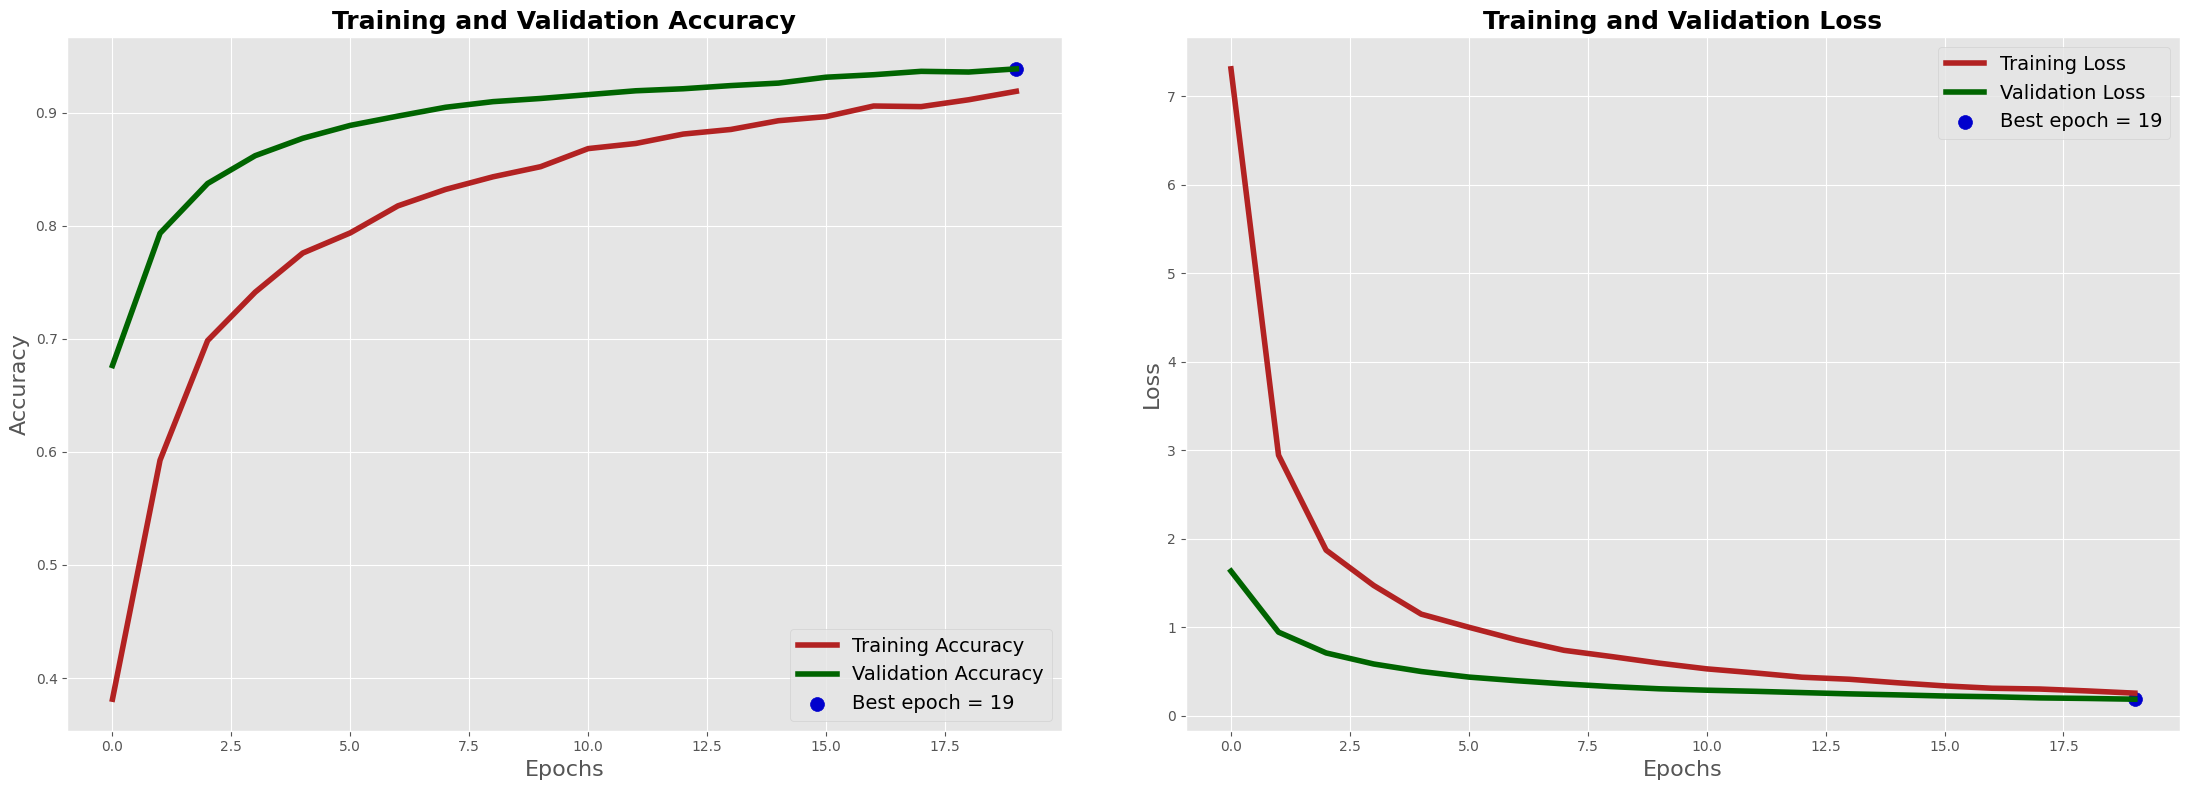

157/157 [==============================] - 7s 41ms/step


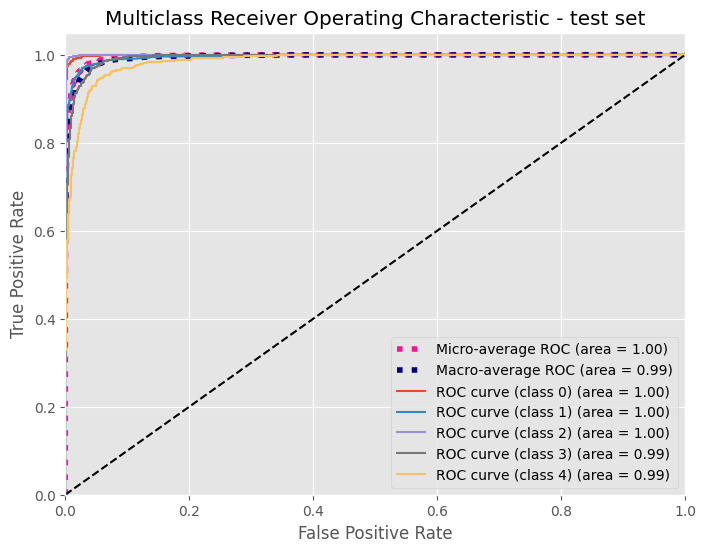

157/157 [==============================] - 7s 42ms/step
[2 1 0 ... 4 3 0] (5000,)
[2 1 0 ... 4 3 0] (5000,)
Classification report of the test set:
                              precision    recall  f1-score   support

         Colon Benign Tissue       0.98      0.98      0.98      1000
        Colon adenocarcinoma       0.95      0.94      0.94      1000
          Lung Benign Tissue       0.99      0.98      0.98      1000
Lung Squamous Cell Carcinoma       0.91      0.92      0.92      1000
         Lung adenocarcinoma       0.88      0.89      0.88      1000

                    accuracy                           0.94      5000
                   macro avg       0.94      0.94      0.94      5000
                weighted avg       0.94      0.94      0.94      5000



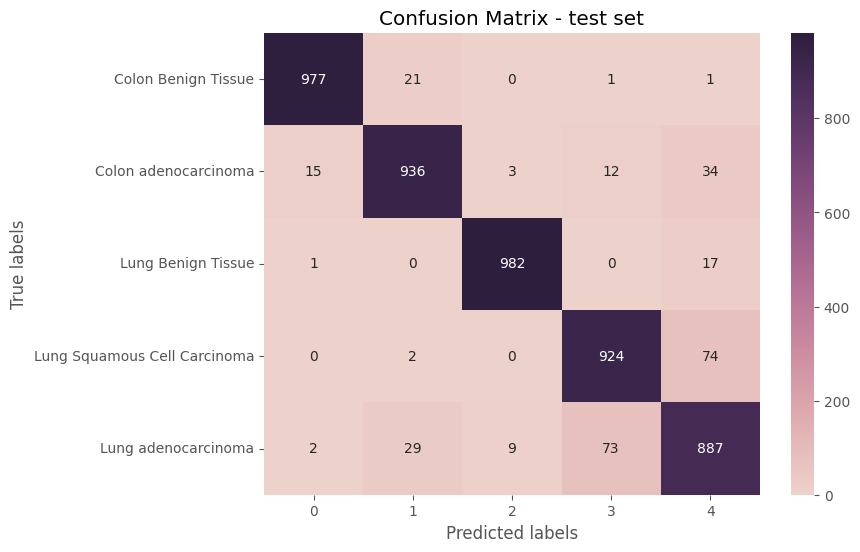

In [ ]:
plot_history(history10)
plot_roc(model_transfer2)
plot_confusion_matrix(model_transfer2, X_test, y_test, 'test')